In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
from typing import Dict, List, Set, Union, Tuple
import yaml
from ast import literal_eval

import json
import pandas as pd
import seaborn as sns

# from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import font_manager as fm, pyplot as plt
import numpy as np
import wandb

# import statsmodels.api as sm

In [3]:
# IMPORTANT: Run as if from project root so that imports work.
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(pardir)
os.getcwd()

'/home/kevin/code/rycolab/context-vs-prior-finetuning'

In [4]:
from model_utils.utils import (
    construct_paths_and_dataset_kwargs,
    construct_test_results_dir,
    EvalConfig,
)
from preprocessing.dataset import load_dataset_from_path

/home/kevin/mambaforge/envs/sftcontext/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not find the bitsandbytes CUDA binary at PosixPath('/home/kevin/mambaforge/envs/sftcontext/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda120.so')
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


#b40426


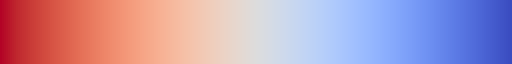

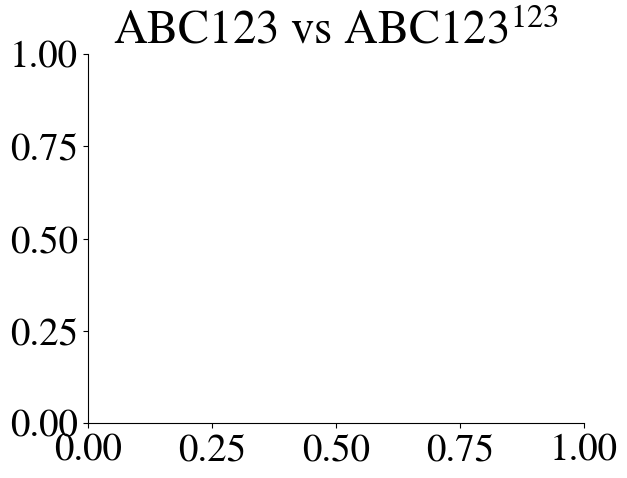

In [5]:
# from analysis.mpl_styles import *
import matplotlib
import seaborn as sns

# matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"

matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
ENTITY_COLOR = palette[0]
CONTEXT_COLOR = palette[1]

OPEN_COLOR = palette[2]
CLOSED_COLOR = palette[3]
LINE_COLOR = palette[7]

REAL_COLOR = palette[5]
FAKE_COLOR = palette[7]
DIFF_COLOR = palette[6]

FT_COLOR = palette[0]
ICL_COLOR = palette[1]
ZS_COLOR = palette[2]

train_methods_colormap = {
    "finetune": FT_COLOR,
    "few_shot": ICL_COLOR,
    "zero-shot": ZS_COLOR,
    "FT": FT_COLOR,
    "IC": ICL_COLOR,
    "ZS": ZS_COLOR,
}


matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")
matplotlib.rcParams["mathtext.rm"]

cm = sns.color_palette("coolwarm_r", as_cmap=True)
cm.set_bad(cm(-np.inf))
print(matplotlib.colors.to_hex(cm(-np.inf)))
cm

In [6]:
##################
### Parameters ###
##################

# Data parameters

# wandb stuff
PROJECT_NAME = "sftcontext"
GROUP_NAME = None
TAGS = ["basefakepedia", "analysis", "summarize", "across-models"]
LOG_DATASETS = True

### Construct dataframes for analysis

In [7]:
analysis_dir = "analysis/summarize/generalization_datasets"
os.makedirs(analysis_dir, exist_ok=True)

In [8]:
dataset_names = ["BaseFakepedia"]
zero_shot_evals = [
    {
        "dataset_name": "BaseFakepedia",
        "subsplit": "nodup_relpid",
        "k_demonstrations": 0,
        "context_weight_format": "instruction",
        "do_steering": False,
    },
    {
        "dataset_name": "MultihopFakepedia",
        "subsplit": "nodup_relpid",
        "k_demonstrations": 0,
        "context_weight_format": "instruction",
        "do_steering": False,
    },
    {
        "dataset_name": "Arithmetic",
        "subsplit": "d2ub9",
        "k_demonstrations": 0,
        "context_weight_format": "instruction",
        "do_steering": False,
    },
]
few_shot_evals = [
    {
        "dataset_name": "BaseFakepedia",
        "subsplit": "nodup_relpid",
        "k_demonstrations": 10,
        "context_weight_format": "instruction",
        "do_steering": False,
    },
    {
        "dataset_name": "MultihopFakepedia",
        "subsplit": "nodup_relpid",
        "k_demonstrations": 10,
        "context_weight_format": "instruction",
        "do_steering": False,
    },
    {
        "dataset_name": "Arithmetic",
        "subsplit": "d2ub9",
        "k_demonstrations": 10,
        "context_weight_format": "instruction",
        "do_steering": False,
    },
]
evals = zero_shot_evals + few_shot_evals
evals = [EvalConfig(**eval) for eval in evals]
print(evals)
subsplit_names = [
    "nodup_relpid",
]
seeds = [1, 2, 3]
train_sizes = [2048]
no_train_statuses = [True, False]
# no_train_statuses = [False]
peft_modules = [
    json.dumps(
        ["q_proj", "k_proj", "v_proj", "o_proj"],
        # ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
        separators=(",", ":"),
    ),
]
context_weight_formats = ["instruction"]
model_id_and_bs_and_ga_and_quantize_and_peft_tuples = [
    ("Meta-Llama-3.1-8B-Instruct", 8, 2, None, True),
    # ("Meta-Llama-3.1-8B", 8, 2, None, True),
    # ("Meta-Llama-3.1-8B", 4, 2, None, True),
    ("Mistral-7B-Instruct-v0.3", 8, 2, None, True),
    # ("Mistral-7B-v0.3", 4, 2, None, True),
    ("gemma-2-9b-it", 2, 8, None, True),
    # ("gemma-2-9b", 4, 2, None, True),
]

[EvalConfig(dataset_name='BaseFakepedia', subsplit='nodup_relpid', k_demonstrations=0, context_weight_format='instruction', do_steering=False), EvalConfig(dataset_name='MultihopFakepedia', subsplit='nodup_relpid', k_demonstrations=0, context_weight_format='instruction', do_steering=False), EvalConfig(dataset_name='Arithmetic', subsplit='d2ub9', k_demonstrations=0, context_weight_format='instruction', do_steering=False), EvalConfig(dataset_name='BaseFakepedia', subsplit='nodup_relpid', k_demonstrations=10, context_weight_format='instruction', do_steering=False), EvalConfig(dataset_name='MultihopFakepedia', subsplit='nodup_relpid', k_demonstrations=10, context_weight_format='instruction', do_steering=False), EvalConfig(dataset_name='Arithmetic', subsplit='d2ub9', k_demonstrations=10, context_weight_format='instruction', do_steering=False)]


In [9]:
overwrite = False
df_dict = []
p_scores_df_dict = []
metrics_dict = []

for ds in dataset_names:
    for sp in subsplit_names:
        for seed in seeds:
            for ts in train_sizes:
                for nts in no_train_statuses:
                    for pm in peft_modules:
                        for cwf in context_weight_formats:
                            for (
                                model_id,
                                bs,
                                ga,
                                quantize,
                                peft,
                            ) in model_id_and_bs_and_ga_and_quantize_and_peft_tuples:
                                dict_vals = dict(
                                    DATASET_NAME=ds,
                                    SUBSPLIT=sp,
                                    SEED=seed,
                                    TRAIN_SIZE=ts,
                                    MODEL_ID=model_id,
                                    PEFT=peft and not nts,
                                    LORA_MODULES=json.loads(pm),
                                    LOAD_IN_4BIT=(quantize == "4bit"),
                                    LOAD_IN_8BIT=(quantize == "8bit"),
                                    BATCH_SZ=bs,
                                    GRAD_ACCUM=ga,
                                    NO_TRAIN=nts,
                                    CONTEXT_WEIGHT_AT_END=False,
                                    CONTEXT_WEIGHT_FORMAT=cwf,
                                    ANSWER_FORMAT_PROMPT_POSITION="end",
                                    ADD_ANSWER_FORMAT_PROMPT=False,
                                )
                                (
                                    data_dir,
                                    input_dir,
                                    model_dir,
                                    results_dir,
                                    val_results_path,
                                    data_id,
                                    full_model_id,
                                    DATASET_KWARGS_IDENTIFIABLE,
                                    MODEL_KWARGS_IDENTIFIABLE,
                                ) = construct_paths_and_dataset_kwargs(**dict_vals)
                                for (
                                    eval_name,
                                    eval_subsplit,
                                    eval_k_demonstrations,
                                    eval_ctx_weight_format,
                                    eval_do_steering,
                                ) in evals:
                                    test_results_dir = construct_test_results_dir(
                                        base_results_dir=results_dir,
                                        subsplit=eval_subsplit,
                                        context_weight_format=eval_ctx_weight_format,
                                        eval_name=eval_name,
                                        k_demonstrations=eval_k_demonstrations,
                                        in_domain_demonstrations=False,
                                        answer_format_prompt_position=None,
                                        add_answer_format_prompt=False,
                                        do_steering=False,
                                        steering_prior_value=None,
                                        steering_context_value=None,
                                        steering_layer=None,
                                    )
                                    test_results_path = os.path.join(
                                        test_results_dir, "test.csv"
                                    )
                                    # test_pscore_results_path = os.path.join(test_results_dir, "test_pscore.csv")
                                    test_metrics_path = os.path.join(
                                        test_results_dir, "metrics.json"
                                    )
                                    test_metrics_query_only_path = os.path.join(
                                        test_results_dir, "metrics_query_only.json"
                                    )
                                    if os.path.isfile(test_results_path):
                                        # Load predictions/results
                                        res = pd.read_csv(
                                            test_results_path,
                                        )
                                        for k, v in dict_vals.items():
                                            if isinstance(v, list):
                                                v = [v] * len(res)
                                            res[k] = v
                                        scores: List[dict] = res.to_dict("records")
                                        df_dict += [
                                            {
                                                **dict_vals,
                                                **{
                                                    "EVAL_NAME": eval_name,
                                                    "EVAL_K_DEMONSTRATIONS": eval_k_demonstrations,
                                                    "EVAL_CTX_WEIGHT_FORMAT": eval_ctx_weight_format,
                                                    "TEACH_METHOD": (
                                                        "few_shot"
                                                        if nts
                                                        else "finetune"
                                                    ),
                                                },
                                                **d,
                                            }
                                            for d in scores
                                        ]
                                    # if os.path.isfile(test_pscore_results_path):
                                    #     # Load predictions/results
                                    #     res = pd.read_csv(
                                    #         test_pscore_results_path,
                                    #     )
                                    #     for k, v in dict_vals.items():
                                    #         if isinstance(v, list):
                                    #             v = [v] * len(res)
                                    #         res[k] = v
                                    #     p_scores: List[dict] = res.to_dict("records")
                                    #     p_scores_df_dict += [{**dict_vals, **{"EVAL_NAME": eval_name, "EVAL_K_DEMONSTRATIONS": eval_k_demonstrations, "EVAL_CTX_WEIGHT_FORMAT": eval_ctx_weight_format, "TEACH_METHOD": "few_shot" if nts else "finetune"}, **d} for d in p_scores]
                                    if os.path.isfile(test_metrics_path):
                                        # Load metrics
                                        metrics = load_dataset_from_path(
                                            test_metrics_path
                                        )
                                        if os.path.isfile(test_metrics_query_only_path):
                                            metrics_query_only = load_dataset_from_path(
                                                test_metrics_query_only_path
                                            )
                                            metrics_query_only = {
                                                f"QO_{k}": v
                                                for k, v in metrics_query_only.items()
                                            }
                                        else:
                                            metrics_query_only = {}
                                        metrics_dict += [
                                            {
                                                **dict_vals,
                                                **{
                                                    "EVAL_NAME": eval_name,
                                                    "EVAL_K_DEMONSTRATIONS": eval_k_demonstrations,
                                                    "EVAL_CTX_WEIGHT_FORMAT": eval_ctx_weight_format,
                                                    "TEACH_METHOD": (
                                                        "few_shot"
                                                        if nts
                                                        else "finetune"
                                                    ),
                                                },
                                                **metrics,
                                                **metrics_query_only,
                                            }
                                        ]

In [10]:
metrics_df = pd.DataFrame(metrics_dict)
# [["EVAL_NAME", "TEACH_METHOD", "accuracy", "QO_accuracy", "pair_accuracy"]]
metrics_df.info()
metrics_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATASET_NAME                   81 non-null     object 
 1   SUBSPLIT                       81 non-null     object 
 2   SEED                           81 non-null     int64  
 3   TRAIN_SIZE                     81 non-null     int64  
 4   MODEL_ID                       81 non-null     object 
 5   PEFT                           81 non-null     bool   
 6   LORA_MODULES                   81 non-null     object 
 7   LOAD_IN_4BIT                   81 non-null     bool   
 8   LOAD_IN_8BIT                   81 non-null     bool   
 9   BATCH_SZ                       81 non-null     int64  
 10  GRAD_ACCUM                     81 non-null     int64  
 11  NO_TRAIN                       81 non-null     bool   
 12  CONTEXT_WEIGHT_AT_END          81 non-null     bool 

Index(['DATASET_NAME', 'SUBSPLIT', 'SEED', 'TRAIN_SIZE', 'MODEL_ID', 'PEFT',
       'LORA_MODULES', 'LOAD_IN_4BIT', 'LOAD_IN_8BIT', 'BATCH_SZ',
       'GRAD_ACCUM', 'NO_TRAIN', 'CONTEXT_WEIGHT_AT_END',
       'CONTEXT_WEIGHT_FORMAT', 'ANSWER_FORMAT_PROMPT_POSITION',
       'ADD_ANSWER_FORMAT_PROMPT', 'EVAL_NAME', 'EVAL_K_DEMONSTRATIONS',
       'EVAL_CTX_WEIGHT_FORMAT', 'TEACH_METHOD', 'acc', 'context_acc',
       'context_mr', 'context_pct_other', 'overall_mr', 'overall_pct_other',
       'pair_acc', 'prior_acc', 'prior_mr', 'prior_pct_other'],
      dtype='object')

In [11]:
metrics_df_short = metrics_df[
    [
        # "DATASET_NAME",
        "SEED",
        "MODEL_ID",
        # "NO_TRAIN",
        "EVAL_NAME",
        "EVAL_K_DEMONSTRATIONS",
        "TEACH_METHOD",
        # "acc",
        "pair_acc",
    ]
]
metrics_df_short["TEACH_METHOD"] = metrics_df_short.apply(
    lambda x: (
        "zero shot"
        if x["TEACH_METHOD"] == "few_shot" and x["EVAL_K_DEMONSTRATIONS"] == 0
        else x["TEACH_METHOD"]
    ),
    axis=1,
)
metrics_df_short = metrics_df_short.rename(
    columns={
        "MODEL_ID": "Model",
        "EVAL_NAME": "Test Dataset",
        "TEACH_METHOD": "Train/Eval Setting",
    }
)
metrics_df_short
# metrics_df_short[]

/tmp/ipykernel_57298/2532063031.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df_short["TEACH_METHOD"] = metrics_df_short.apply(


,SEED,Model,Test Dataset,EVAL_K_DEMONSTRATIONS,Train/Eval Setting,pair_acc
0,1,Meta-Llama-3.1-8B-Instruct,BaseFakepedia,0,zero shot,0.448
1,1,Meta-Llama-3.1-8B-Instruct,MultihopFakepedia,0,zero shot,0.400
2,1,Meta-Llama-3.1-8B-Instruct,Arithmetic,0,zero shot,0.312
3,1,Meta-Llama-3.1-8B-Instruct,BaseFakepedia,10,few_shot,0.868
4,1,Meta-Llama-3.1-8B-Instruct,MultihopFakepedia,10,few_shot,0.714
...,...,...,...,...,...,...
76,3,Mistral-7B-Instruct-v0.3,MultihopFakepedia,0,finetune,0.258
77,3,Mistral-7B-Instruct-v0.3,Arithmetic,0,finetune,0.252
78,3,gemma-2-9b-it,BaseFakepedia,0,finetune,0.844
79,3,gemma-2-9b-it,MultihopFakepedia,0,finetune,0.796


In [12]:
# Define the desired order for Test Dataset and Train/Eval Setting
dataset_order = ["BaseFakepedia", "MultihopFakepedia", "Arithmetic"]
setting_order = ["zero shot", "few_shot", "finetune"]

# Create category datatypes with ordered categories
metrics_df_short["Test Dataset"] = pd.Categorical(
    metrics_df_short["Test Dataset"], categories=dataset_order, ordered=True
)
metrics_df_short["Train/Eval Setting"] = pd.Categorical(
    metrics_df_short["Train/Eval Setting"], categories=setting_order, ordered=True
)

# Sort the DataFrame
metrics_df_short = metrics_df_short.sort_values(
    ["Model", "Test Dataset", "Train/Eval Setting"]
)
metrics_df_short

,SEED,Model,Test Dataset,EVAL_K_DEMONSTRATIONS,Train/Eval Setting,pair_acc
0,1,Meta-Llama-3.1-8B-Instruct,BaseFakepedia,0,zero shot,0.448
27,2,Meta-Llama-3.1-8B-Instruct,BaseFakepedia,0,zero shot,0.448
54,3,Meta-Llama-3.1-8B-Instruct,BaseFakepedia,0,zero shot,0.448
3,1,Meta-Llama-3.1-8B-Instruct,BaseFakepedia,10,few_shot,0.868
30,2,Meta-Llama-3.1-8B-Instruct,BaseFakepedia,10,few_shot,0.862
...,...,...,...,...,...,...
44,2,gemma-2-9b-it,Arithmetic,10,few_shot,0.464
71,3,gemma-2-9b-it,Arithmetic,10,few_shot,0.440
26,1,gemma-2-9b-it,Arithmetic,0,finetune,0.602
53,2,gemma-2-9b-it,Arithmetic,0,finetune,0.626


In [13]:
metrics_df_avg = metrics_df_short.groupby(
    [
        "Model",
        "Test Dataset",
        "Train/Eval Setting",
    ]
).agg(
    pair_acc_mean=("pair_acc", "mean"),
    pair_acc_std=("pair_acc", "std"),
    pair_acc_sem=("pair_acc", "sem"),
)
# metrics_df_avg["pair_acc_mean"]
metrics_df_avg["Pair Acc (\pm SD)"] = metrics_df_avg.apply(
    lambda x: f"{x['pair_acc_mean']:.2f} \pm {x['pair_acc_std']:.2f}", axis=1
)
metrics_df_avg
# metrics_df_avg.reset_index()

/tmp/ipykernel_57298/2733578268.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  metrics_df_avg = metrics_df_short.groupby(


pair_acc_mean  \
Model                      Test Dataset      Train/Eval Setting                  
Meta-Llama-3.1-8B-Instruct BaseFakepedia     zero shot                0.448000   
                                             few_shot                 0.884667   
                                             finetune                 0.931333   
                           MultihopFakepedia zero shot                0.400000   
                                             few_shot                 0.650667   
                                             finetune                 0.881333   
                           Arithmetic        zero shot                0.312000   
                                             few_shot                 0.410667   
                                             finetune                 0.539333   
Mistral-7B-Instruct-v0.3   BaseFakepedia     zero shot                0.114000   
                                             few_shot                 0.338667   
                                             finetune                 0.920000   
                           MultihopFakepedia zero shot                0.142000   
                                             few_shot                 0.202000   
                                             finetune                 0.414000   
                           Arithmetic        zero shot                0.088000   
                                             few_shot                 0.148667   
                                             finetune                 0.302667   
gemma-2-9b-it              BaseFakepedia     zero shot                0.446667   
                                             few_shot                 0.825333   
                                             finetune                 0.844000   
                           MultihopFakepedia zero shot                0.606667   
                                             few_shot                 0.829333   
                                             finetune                 0.783333   
                           Arithmetic        zero shot                0.548667   
                                             few_shot                 0.434667   
                                             finetune                 0.627333   

                                                                 pair_acc_std  \
Model                      Test Dataset      Train/Eval Setting                 
Meta-Llama-3.1-8B-Instruct BaseFakepedia     zero shot               0.000000   
                                             few_shot                0.034196   
                                             finetune                0.016042   
                           MultihopFakepedia zero shot               0.000000   
                                             few_shot                0.111433   
                                             finetune                0.032021   
                           Arithmetic        zero shot               0.000000   
                                             few_shot                0.024111   
                                             finetune                0.006429   
Mistral-7B-Instruct-v0.3   BaseFakepedia     zero shot               0.000000   
                                             few_shot                0.024111   
                                             finetune                0.025534   
                           MultihopFakepedia zero shot               0.000000   
                                             few_shot                0.027055   
                                             finetune                0.136880   
                           Arithmetic        zero shot               0.000000   
                                             few_shot                0.021385   
                                             finetune                0.045490   
gemma-2-9b-it              BaseFakepedia     zero shot            

In [14]:
metrics_df_unpivoted = metrics_df_avg.reset_index().pivot(
    index=["Model", "Train/Eval Setting"],
    columns="Test Dataset",
    values="Pair Acc (\pm SD)",
)
metrics_df_unpivoted

Test Dataset                                   BaseFakepedia  \
Model                      Train/Eval Setting                  
Meta-Llama-3.1-8B-Instruct zero shot           0.45 \pm 0.00   
                           few_shot            0.88 \pm 0.03   
                           finetune            0.93 \pm 0.02   
Mistral-7B-Instruct-v0.3   zero shot           0.11 \pm 0.00   
                           few_shot            0.34 \pm 0.02   
                           finetune            0.92 \pm 0.03   
gemma-2-9b-it              zero shot           0.45 \pm 0.00   
                           few_shot            0.83 \pm 0.05   
                           finetune            0.84 \pm 0.00   

Test Dataset                                  MultihopFakepedia     Arithmetic  
Model                      Train/Eval Setting                                   
Meta-Llama-3.1-8B-Instruct zero shot              0.40 \pm 0.00  0.31 \pm 0.00  
                           few_shot               0.65 \pm 0.11  0.41 \pm 0.02  
                           finetune               0.88 \pm 0.03  0.54 \pm 0.01  
Mistral-7B-Instruct-v0.3   zero shot              0.14 \pm 0.00  0.09 \pm 0.00  
                           few_shot               0.20 \pm 0.03  0.15 \pm 0.02  
                           finetune               0.41 \pm 0.14  0.30 \pm 0.05  
gemma-2-9b-it              zero shot              0.61 \pm 0.00  0.55 \pm 0.00  
                           few_shot               0.83 \pm 0.03  0.43 \pm 0.03  
                           finetune               0.78 \pm 0.02  0.63 \pm 0.03

In [15]:
# metrics_df_unpivoted = metrics_df_avg.reset_index().pivot(
#     index=["Model", "Train/Eval Setting"],
#     columns="Test Dataset",
#     values="pair_acc_mean",
# )
# df = metrics_df_unpivoted.reset_index()
# df = df[df["Model"] == "Meta-Llama-3.1-8B"][
#     ["Train/Eval Setting", "BaseFakepedia", "MultihopFakepedia", "Arithmetic"]
# ].set_index("Train/Eval Setting")
# print(df)

# sns.heatmap(
#     data=df,
#     annot=True,
#     # fmt="s",
#     cmap="coolwarm",
#     cbar_kws={"label": "Pair Accuracy"},
# )

In [16]:
print(
    metrics_df_unpivoted.to_latex(
        multicolumn=True,
        multirow=True,
    )
)

\begin{tabular}{lllll}
\toprule
 & Test Dataset & BaseFakepedia & MultihopFakepedia & Arithmetic \\
Model & Train/Eval Setting &  &  &  \\
\midrule
\multirow[t]{3}{*}{Meta-Llama-3.1-8B-Instruct} & zero shot & 0.45 \pm 0.00 & 0.40 \pm 0.00 & 0.31 \pm 0.00 \\
 & few_shot & 0.88 \pm 0.03 & 0.65 \pm 0.11 & 0.41 \pm 0.02 \\
 & finetune & 0.93 \pm 0.02 & 0.88 \pm 0.03 & 0.54 \pm 0.01 \\
\cline{1-5}
\multirow[t]{3}{*}{Mistral-7B-Instruct-v0.3} & zero shot & 0.11 \pm 0.00 & 0.14 \pm 0.00 & 0.09 \pm 0.00 \\
 & few_shot & 0.34 \pm 0.02 & 0.20 \pm 0.03 & 0.15 \pm 0.02 \\
 & finetune & 0.92 \pm 0.03 & 0.41 \pm 0.14 & 0.30 \pm 0.05 \\
\cline{1-5}
\multirow[t]{3}{*}{gemma-2-9b-it} & zero shot & 0.45 \pm 0.00 & 0.61 \pm 0.00 & 0.55 \pm 0.00 \\
 & few_shot & 0.83 \pm 0.05 & 0.83 \pm 0.03 & 0.43 \pm 0.03 \\
 & finetune & 0.84 \pm 0.00 & 0.78 \pm 0.02 & 0.63 \pm 0.03 \\
\cline{1-5}
\bottomrule
\end{tabular}



In [17]:
# metrics_df_avg.to_latex()
# Convert to LaTeX
latex_table = (
    metrics_df_avg["Pair Acc (\\pm SD)"]
    .reset_index()
    .to_latex(index=False, escape=False, column_format="lllr")
)

# Improve the LaTeX output
latex_table = latex_table.replace("pair\_acc\_mean", "pair\\_acc\\_mean")
latex_table = latex_table.replace("pair\_acc\_std", "pair\\_acc\\_std")
latex_table = latex_table.replace("pair\_acc\_sem", "pair\\_acc\\_sem")
latex_table = latex_table.replace("Train/Eval Setting", "Train/Eval Setting")
latex_table = latex_table.replace("\pm", "$\\pm$")

print(latex_table)

# Optionally, save to a file
with open("table.tex", "w") as f:
    f.write(latex_table)

\begin{tabular}{lllr}
\toprule
Model & Test Dataset & Train/Eval Setting & Pair Acc ($\pm$ SD) \\
\midrule
Meta-Llama-3.1-8B-Instruct & BaseFakepedia & zero shot & 0.45 $\pm$ 0.00 \\
Meta-Llama-3.1-8B-Instruct & BaseFakepedia & few_shot & 0.88 $\pm$ 0.03 \\
Meta-Llama-3.1-8B-Instruct & BaseFakepedia & finetune & 0.93 $\pm$ 0.02 \\
Meta-Llama-3.1-8B-Instruct & MultihopFakepedia & zero shot & 0.40 $\pm$ 0.00 \\
Meta-Llama-3.1-8B-Instruct & MultihopFakepedia & few_shot & 0.65 $\pm$ 0.11 \\
Meta-Llama-3.1-8B-Instruct & MultihopFakepedia & finetune & 0.88 $\pm$ 0.03 \\
Meta-Llama-3.1-8B-Instruct & Arithmetic & zero shot & 0.31 $\pm$ 0.00 \\
Meta-Llama-3.1-8B-Instruct & Arithmetic & few_shot & 0.41 $\pm$ 0.02 \\
Meta-Llama-3.1-8B-Instruct & Arithmetic & finetune & 0.54 $\pm$ 0.01 \\
Mistral-7B-Instruct-v0.3 & BaseFakepedia & zero shot & 0.11 $\pm$ 0.00 \\
Mistral-7B-Instruct-v0.3 & BaseFakepedia & few_shot & 0.34 $\pm$ 0.02 \\
Mistral-7B-Instruct-v0.3 & BaseFakepedia & finetune & 0.92 $\pm$ 

In [18]:
metrics_df_short

,SEED,Model,Test Dataset,EVAL_K_DEMONSTRATIONS,Train/Eval Setting,pair_acc
0,1,Meta-Llama-3.1-8B-Instruct,BaseFakepedia,0,zero shot,0.448
27,2,Meta-Llama-3.1-8B-Instruct,BaseFakepedia,0,zero shot,0.448
54,3,Meta-Llama-3.1-8B-Instruct,BaseFakepedia,0,zero shot,0.448
3,1,Meta-Llama-3.1-8B-Instruct,BaseFakepedia,10,few_shot,0.868
30,2,Meta-Llama-3.1-8B-Instruct,BaseFakepedia,10,few_shot,0.862
...,...,...,...,...,...,...
44,2,gemma-2-9b-it,Arithmetic,10,few_shot,0.464
71,3,gemma-2-9b-it,Arithmetic,10,few_shot,0.440
26,1,gemma-2-9b-it,Arithmetic,0,finetune,0.602
53,2,gemma-2-9b-it,Arithmetic,0,finetune,0.626


In [19]:
!pip install --upgrade nbformat

DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'; python_version >= "3.6". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [20]:
# !pip install git+https://github.com/jkminder/pycolors.git
from pycolors import TailwindColorPalette

COLORS = TailwindColorPalette()


def get_label_color(label, COLORS):
    if "FT" in label:
        return COLORS.get_shade(0, 700)
    elif "FS" in label or "ICL" in label:
        return COLORS.get_shade(9, 600)
    elif "ZS" in label:
        return COLORS.get_shade(6, 600)
    else:
        return "black"  # Default color

In [33]:
for model, metrics_df_short_i_only in metrics_df_short.groupby("Model"):
    # metrics_df_short_i_only = metrics_df_short[
    #     (metrics_df_short["Model"] == "Meta-Llama-3.1-8B-Instruct")
    # ]
    # metrics_df_short_i_only = metrics_df_short[
    #     (metrics_df_short["Model"] == "gemma-2-9b-it")
    # ]
    # metrics_df_short_i_only = metrics_df_short_i_only[
    #     (metrics_df_short_i_only["Model"] == "Mistral-7B-Instruct-v0.3")
    # ]
    import plotly.graph_objects as go
    import pandas as pd

    rename_dict = {"few_shot": "ICL", "zero shot": "ZS", "finetune": "FT"}

    metrics_df_short_i_only["Train Method"] = metrics_df_short_i_only[
        "Train/Eval Setting"
    ].replace(rename_dict)

    aggregated_data = (
        metrics_df_short_i_only.groupby(["Test Dataset", "Train Method"])["pair_acc"]
        .agg(["mean", "std"])
        .reset_index()
    )

    fig = go.Figure()

    order = ["ZS", "ICL", "FT"]

    def get_custom_color(setting):
        return get_label_color(setting, COLORS)

    colors = [get_custom_color(setting) for setting in order]
    print(colors)

    for setting, color in zip(order, colors):
        data = aggregated_data[aggregated_data["Train Method"] == setting]
        fig.add_trace(
            go.Bar(
                x=data["Test Dataset"],
                y=data["mean"],
                name=setting,
                error_y=dict(
                    type="data",
                    array=data["std"],
                    visible=True,
                    thickness=6,
                    width=9,
                ),
                marker_color=color,
            )
        )

    fig.update_layout(
        xaxis_title="Test Dataset",
        yaxis_title="PairAcc",
        barmode="group",
        font=dict(family="Computer Modern", size=24),
        margin=dict(l=50, r=50, t=50, b=50),
        showlegend=True,
    )

    fig.update_xaxes(
        title_font=dict(family="Computer Modern", size=72),
        tickfont=dict(family="Computer Modern", size=50),
    )
    fig.update_yaxes(
        title_font=dict(family="Computer Modern", size=72),
        tickfont=dict(family="Computer Modern", size=50),
    )

    fig.update_layout(
        legend=dict(
            x=0.785,
            y=0.98,
            traceorder="normal",
            font=dict(
                family="Computer Modern",
                size=60,
                # color="black"
            ),
        )
    )
    # legend=dict(font=dict(family="Computer Modern", size=60)))

    fig.update_layout(
        uniformtext_minsize=25,
        uniformtext_mode="show",
        yaxis_range=[0, 1],
    )
    fig.write_image(f"{model}_generalization_dataset.pdf", format="pdf")
    fig.write_image(
        f"{model}_generalization_dataset.png",
        format="png",
        scale=2,
        width=1800,
        height=900,
    )
    fig.show()

/tmp/ipykernel_57298/4037465814.py:18: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.

/tmp/ipykernel_57298/4037465814.py:21: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



['#fd850d', '#cf2e33', '#009ddb']


/tmp/ipykernel_57298/4037465814.py:18: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.

/tmp/ipykernel_57298/4037465814.py:21: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



['#fd850d', '#cf2e33', '#009ddb']


/tmp/ipykernel_57298/4037465814.py:18: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.

/tmp/ipykernel_57298/4037465814.py:21: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



['#fd850d', '#cf2e33', '#009ddb']
